In [1]:
import xarray as xr
import numpy as np
import s3fs
from skimage import measure, feature
from sklearn import preprocessing
import matplotlib.pyplot as plt
import echopype as ep

# Download dataset
Download netcdf dataset from imos-data/IMOS/SOOP/SOOP-BA/VLMJ_Investigator/

In [16]:
fname = 'D:/GLIDER2018/Echosounder/Echosounder/nc_files/GLIDER_SB_2018_v5-Phase0-D20180625-T170658-1.nc'
ed = ep.open_converted(fname)
ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')

<string>:6: DeprecationWarning: `np.alen` is deprecated, use `len` instead


In [12]:
#ds.coords['range_bin']=np.array(ds.range[0,0,:]) # replace range bin with depth value/range

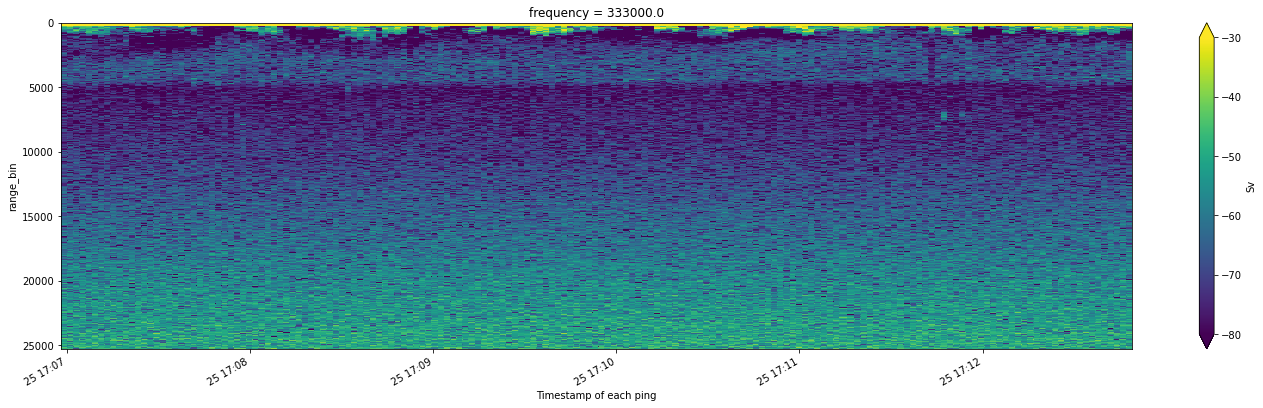

In [17]:
fig = (ds.Sv).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

# Get layers of interest

Working on one channel at a time so please select the channel first

In [87]:
ds_s = ds[['Sv']].isel(frequency=0,range_bin=slice(300,10000), ping_time=slice(0,30))
ds_s

<xarray.Dataset>
Dimensions:    (ping_time: 30, range_bin: 9700)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T17:06:59.104000 ... 2018...
    frequency  float64 3.33e+05
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999
Data variables:
    Sv         (ping_time, range_bin) float64 -14.97 -23.59 ... -72.72 -65.82

## Interpolation along DEPTH axis and drop all nan slices in TIME

In [88]:
ds_s = ds_s.interpolate_na('range_bin', method="linear", fill_value="extrapolate")
ds_s = ds_s.dropna('ping_time')
ds_s

<xarray.Dataset>
Dimensions:    (ping_time: 30, range_bin: 9700)
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T17:06:59.104000 ... 2018...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999
Data variables:
    Sv         (ping_time, range_bin) float64 -14.97 -23.59 ... -72.72 -65.82

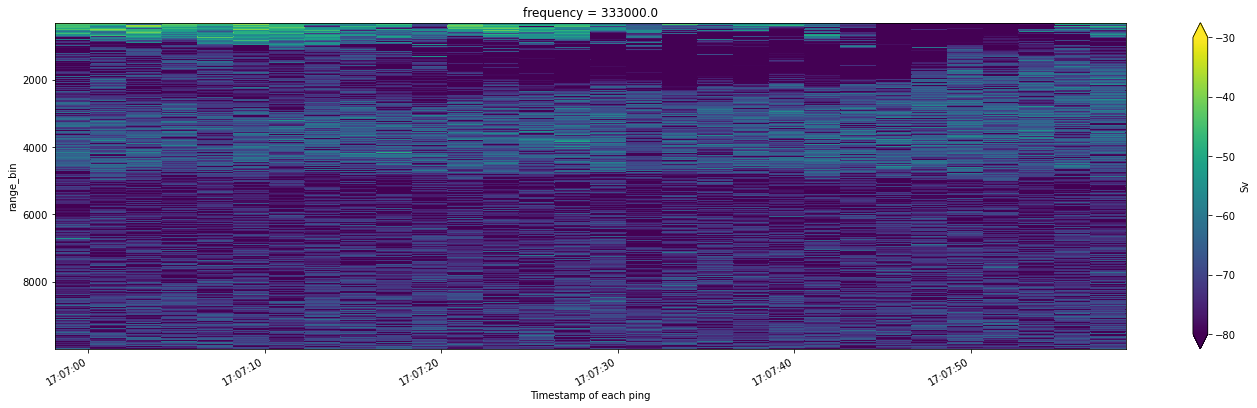

In [89]:
fig = ds_s.Sv.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30).figure
plt.gca().invert_yaxis()

In [90]:
fig.savefig('initial_img.png')

In [91]:
ds_s['Sv']

<xarray.DataArray 'Sv' (ping_time: 30, range_bin: 9700)>
array([[-14.97225987, -23.5864616 , -19.49990003, ..., -68.10049853,
        -72.41959573, -63.77578172],
       [-17.73408383, -24.41333514, -20.9288716 , ..., -68.37543306,
        -68.34882757, -78.82230899],
       [-15.14554985, -24.30892661, -20.79955288, ..., -68.85115059,
        -64.49515988, -82.88101204],
       ...,
       [-16.6433139 , -24.30113776, -19.96321343, ..., -80.27635037,
        -71.55034322, -73.96010873],
       [-14.66876184, -25.74721439, -25.1376984 , ..., -72.96886076,
        -72.43744501, -80.72819754],
       [-14.67513549, -24.03124139, -18.43207723, ..., -80.21917222,
        -72.72167409, -65.8234729 ]])
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T17:06:59.104000 ... 2018...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999

## Using mean filtering to smooth the image and remove noise

C:\Users\mbd\anaconda3\lib\site-packages\xarray\core\variable.py:131: DeprecationWarning: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property. This will raise a TypeError in 0.19.0.
  DeprecationWarning,
C:\Users\mbd\anaconda3\lib\site-packages\xarray\core\variable.py:131: DeprecationWarning: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property. This will raise a TypeError in 0.19.0.
  DeprecationWarning,


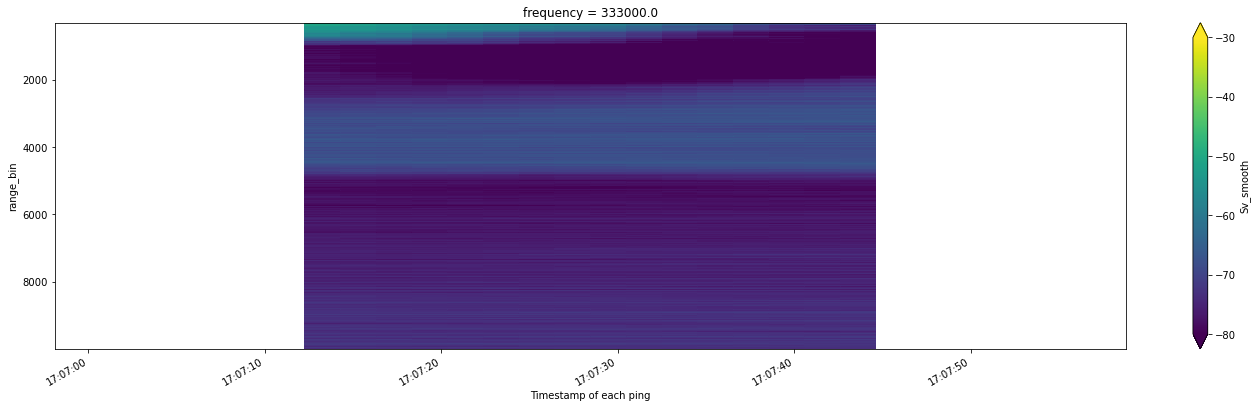

In [92]:
Sv_smooth = ds_s['Sv'].rolling(ping_time=15, center=True).mean().rolling(range_bin=5, center=True).mean()
ds_s = ds_s.assign(variables={"Sv_smooth": (('ping_time', 'range_bin'), Sv_smooth)})
(ds_s.Sv_smooth).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

# Simple thresholding using the mean

In [93]:
from skimage.filters import threshold_otsu
thresh = ds_s['Sv_smooth'].mean()# threshold_otsu(Sv_smooth.data)
thresh

<xarray.DataArray 'Sv_smooth' ()>
array(-74.2908205)
Coordinates:
    frequency  float64 3.33e+05

In [102]:
ds_s = ds_s.assign(variables={"Sv_mask": (('ping_time', 'range_bin'), (ds_s['Sv_smooth']>thresh))})
ds_s

C:\Users\mbd\anaconda3\lib\site-packages\xarray\core\variable.py:131: DeprecationWarning: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property. This will raise a TypeError in 0.19.0.
  DeprecationWarning,
C:\Users\mbd\anaconda3\lib\site-packages\xarray\core\variable.py:131: DeprecationWarning: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property. This will raise a TypeError in 0.19.0.
  DeprecationWarning,


<xarray.Dataset>
Dimensions:    (ping_time: 30, range_bin: 9700)
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T17:06:59.104000 ... 2018...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999
Data variables:
    Sv         (ping_time, range_bin) float64 -14.97 -23.59 ... -72.72 -65.82
    Sv_smooth  (ping_time, range_bin) float64 nan nan nan nan ... nan nan nan
    Sv_mask    (ping_time, range_bin) bool False False False ... False False
    edges      (ping_time, range_bin) bool False False False ... False False

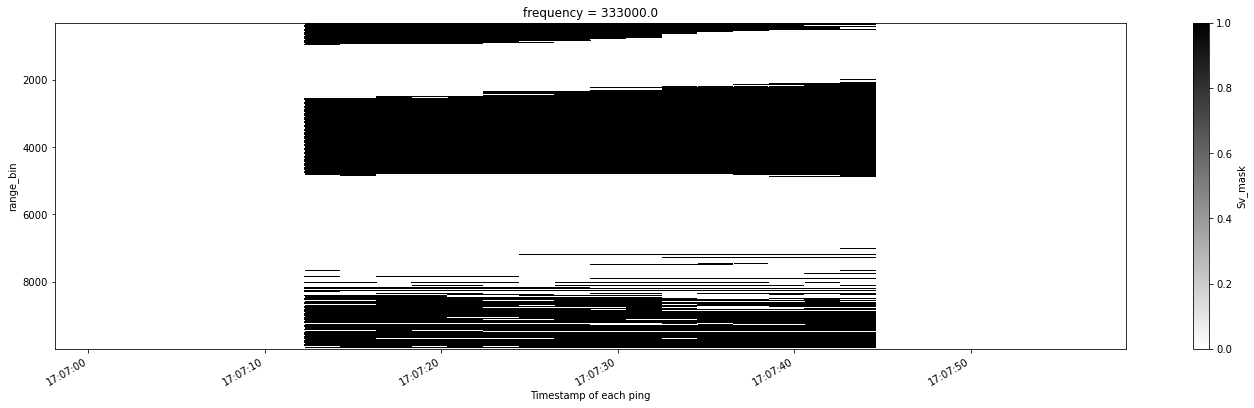

In [103]:
ds_s["Sv_mask"].plot(x='ping_time', size=6, aspect=4, cmap="binary")
plt.gca().invert_yaxis()

# Edge detection

Using canny filtering to get the edges of the layers

In [104]:
from skimage import feature
edges = feature.canny(ds_s['Sv_mask'].data, sigma=11)
ds_s = ds_s.assign(variables={"edges": (('ping_time', 'range_bin'), edges)})

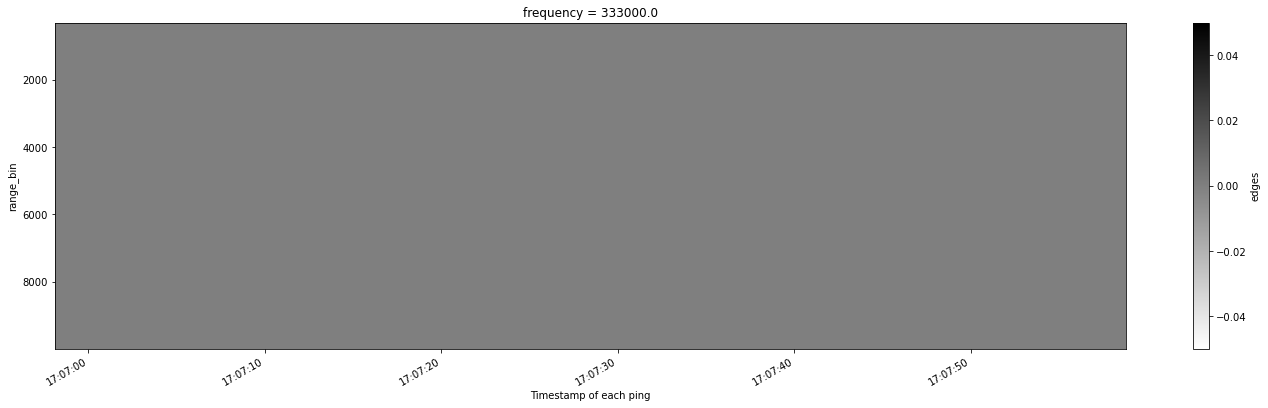

In [105]:
fig = ds_s["edges"].plot(x='ping_time', size=6, aspect=4, cmap="binary").figure
plt.gca().invert_yaxis()

In [106]:
fig.savefig('contours.png')

# Apply mask on initial image

In [107]:
filtered = ds_s['Sv'].where(ds_s['Sv_mask'])
filtered

<xarray.DataArray 'Sv' (ping_time: 30, range_bin: 9700)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T17:06:59.104000 ... 2018...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999

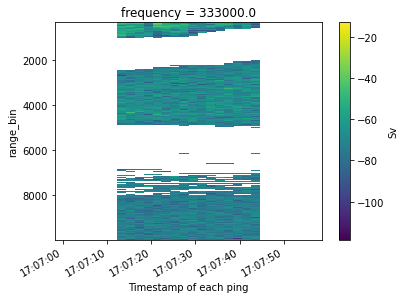

In [114]:
fig = (filtered).plot(x='ping_time', cmap="viridis").figure
plt.gca().invert_yaxis()

In [110]:
fig.savefig('mask_applied.png')

## Adding edges on the initial image

not sure how to have both overlay 

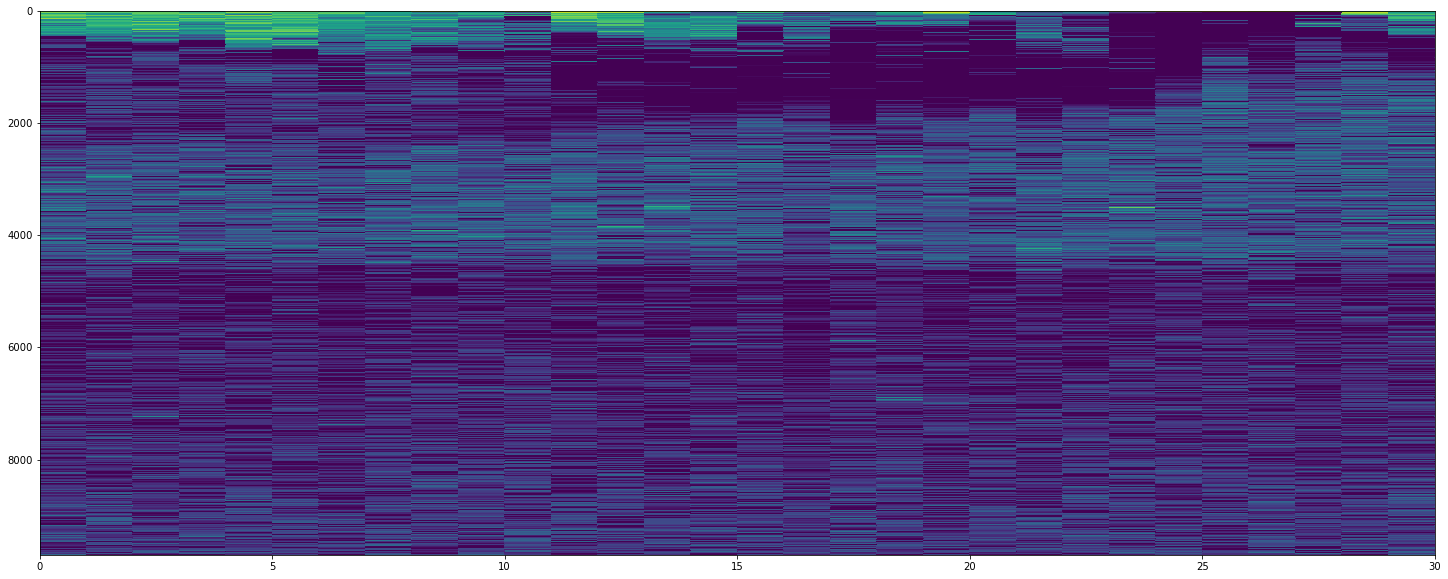

In [122]:
fig, ax = plt.subplots(figsize = (25,10))
ax.pcolormesh(ds_s["Sv"].data.T, cmap="viridis", vmax=-30, vmin=-80)
#ax.pcolormesh(ds_s['edges'].T, cmap="binary")
plt.gca().invert_yaxis()

# Other methods

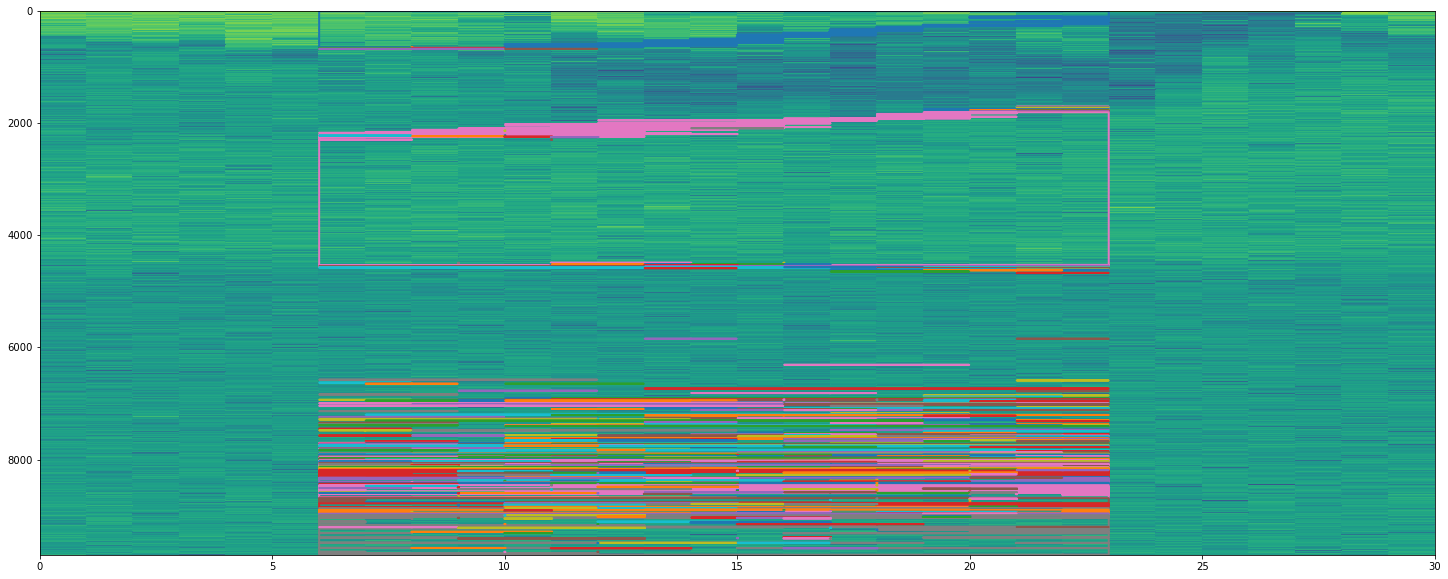

In [123]:
from skimage import measure

# Find contours at a constant value of 0.8
r = ds_s["Sv_mask"].data.T
contours = measure.find_contours(r, 0.01)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize = (25,10))
ax.pcolormesh(ds_s["Sv"].data.T)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.invert_yaxis()
plt.show()

C:\Users\mbd\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if __name__ == '__main__':


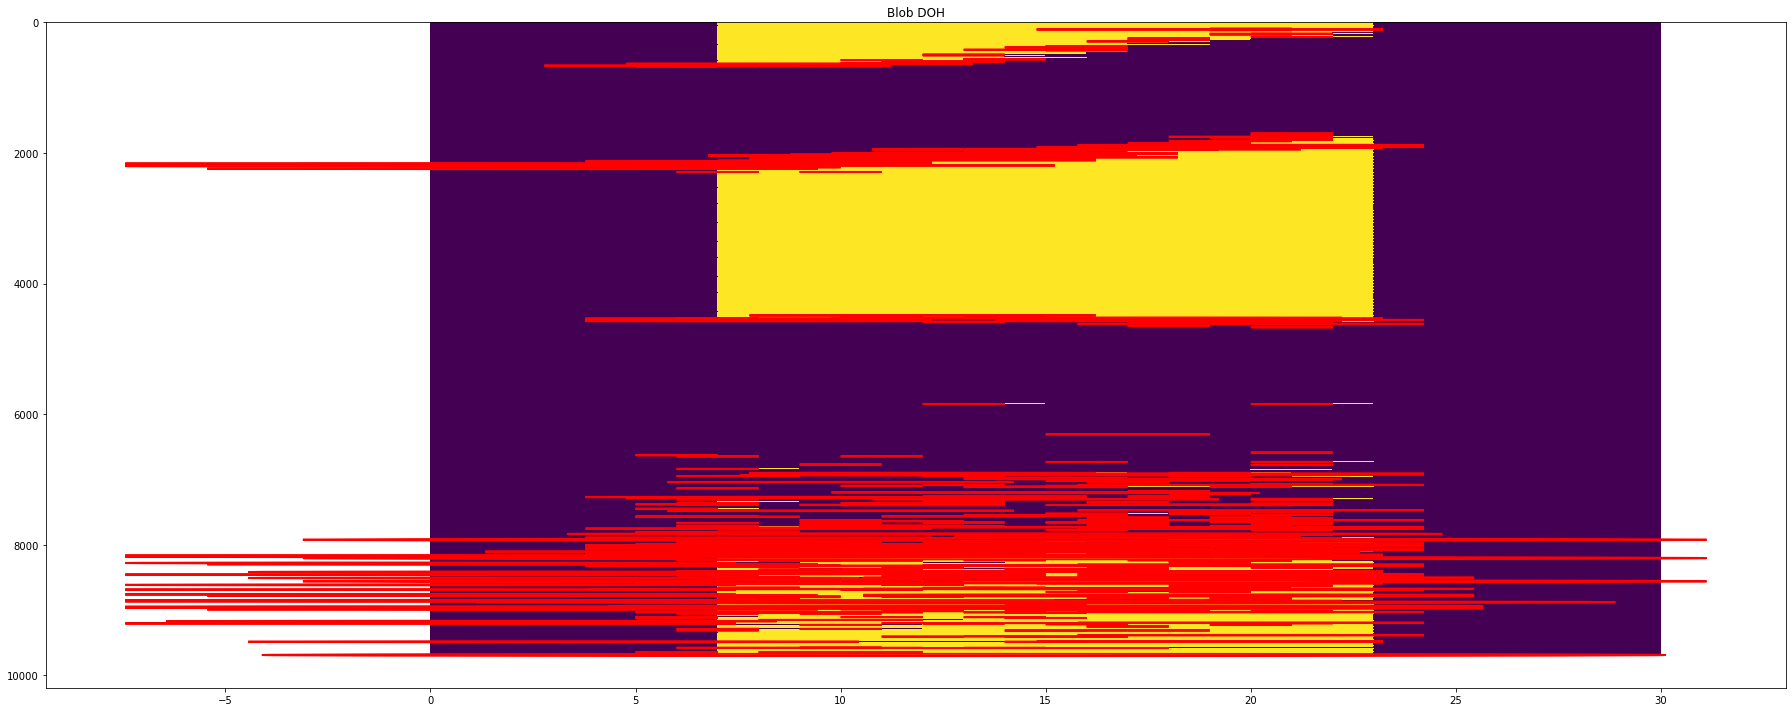

In [124]:
from math import sqrt
from skimage.feature import blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


image = ds_s['Sv_mask'].T
image_gray = rgb2gray(image)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.02)

fig, ax = plt.subplots(figsize = (25,10))
ax.set_title("Blob DOH")
ax.pcolormesh(image)
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Ressources to other methods

* Trained classifier (random forest): https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_trainable_segmentation.html#sphx-glr-auto-examples-segmentation-plot-trainable-segmentation-py

* Marching suqares algorithm: https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html#sphx-glr-auto-examples-edges-plot-contours-py

* Blob Determinant of Hessian method: https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_doh
